In [23]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os
from dotenv import load_dotenv

load_dotenv("./.env")

client_id = os.environ.get("SPOTIFY_CLIENT_ID")
client_secret = os.environ.get("SPOTIFY_CLIENT_SECRET")

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id, client_secret), requests_timeout=45)

In [24]:
import pandas as pd
from joblib import Parallel, delayed

df = pd.read_csv('tracks5.csv')
list_songs = df['0'].dropna().values.tolist()


In [25]:
def getFeatures(id):
    try:
        return sp.audio_features(id)
    except:
        return None

features = Parallel(
    n_jobs=50
)(
    delayed(getFeatures)(i) for i in list_songs
)



Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached
Max Retries reached


In [38]:
features2 = [i for i in features if i != None]
flattened = [b for b in features2 for b in b if b]


In [39]:
df2 = pd.DataFrame(flattened)

# df2.to_csv('features.csv', index=False)

In [40]:
df2.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.683,0.8460,7,-3.551,1,0.0422,0.06340,0.000000,0.3460,0.7060,131.884,audio_features,3hlWUNjAlbZ6nOjAbrivBv,spotify:track:3hlWUNjAlbZ6nOjAbrivBv,https://api.spotify.com/v1/tracks/3hlWUNjAlbZ6...,https://api.spotify.com/v1/audio-analysis/3hlW...,217000,4
1,0.122,0.0261,4,-32.465,0,0.0339,0.82500,0.903000,0.1090,0.0323,95.484,audio_features,464ZqN4UqyJTbibnQfsBeG,spotify:track:464ZqN4UqyJTbibnQfsBeG,https://api.spotify.com/v1/tracks/464ZqN4UqyJT...,https://api.spotify.com/v1/audio-analysis/464Z...,424089,4
2,0.432,0.5550,2,-7.336,1,0.0330,0.62500,0.000038,0.1280,0.5270,79.369,audio_features,7FhBSLKkjTFTcqsnDFye9d,spotify:track:7FhBSLKkjTFTcqsnDFye9d,https://api.spotify.com/v1/tracks/7FhBSLKkjTFT...,https://api.spotify.com/v1/audio-analysis/7FhB...,222307,4
3,0.621,0.8260,2,-5.786,1,0.0334,0.00275,0.058300,0.2280,0.7170,119.989,audio_features,5HvN5wQFNTNxlNBgeaPGbf,spotify:track:5HvN5wQFNTNxlNBgeaPGbf,https://api.spotify.com/v1/tracks/5HvN5wQFNTNx...,https://api.spotify.com/v1/audio-analysis/5HvN...,204693,4
4,0.569,0.4450,0,-5.159,1,0.0283,0.30700,0.000003,0.0957,0.4780,78.993,audio_features,4w9jtaewB2iRNCeEKnaAP5,spotify:track:4w9jtaewB2iRNCeEKnaAP5,https://api.spotify.com/v1/tracks/4w9jtaewB2iR...,https://api.spotify.com/v1/audio-analysis/4w9j...,311771,4


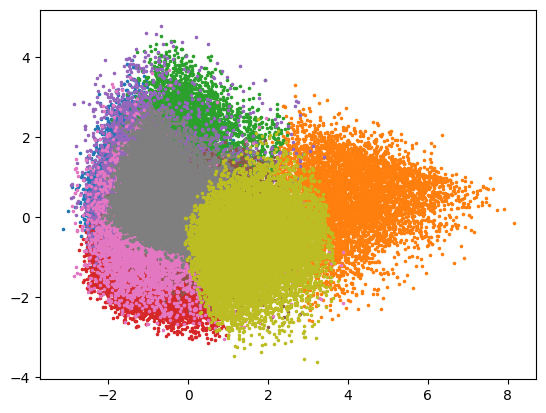

In [55]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import numpy as np

def getClusterIds(df):
    # Normalize the data
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(df2[["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]])
    # df_normalized = pd.DataFrame(X_normalized, columns=["danceability", "energy",  "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"])

    # Perform PCA
    pca = PCA(n_components=9)
    pca.fit(X_normalized)
    X_pca = pca.transform(X_normalized)

    # Predict clusters using KMeans
    kmeans = KMeans(n_clusters=9, n_init=10) # TODO: Find optimal number of clusters using an elbow graph
    kmeans.fit(X_pca)
    cluster_ids = kmeans.predict(X_pca)
    return cluster_ids

cluster_ids = getClusterIds(df2)

# Plot clusters
for c in np.unique(cluster_ids):
    plt.scatter(X_pca[cluster_ids == c, 0], X_pca[cluster_ids == c, 1], marker='.', s=10)

In [48]:
# Add cluster ids to dataframe
df2['cluster'] = cluster_ids


0        2
1        0
2        4
3        2
4        6
        ..
76229    8
76230    7
76231    4
76232    2
76233    1
Name: cluster, Length: 76234, dtype: int32

In [49]:
df2.to_csv('features_clustered.csv', index=False)

In [70]:
# Final UI:
# - Input: song name
inpt = input("Enter song name: ")
# - Search for song in Spotify
results = sp.search(q=inpt, limit=1)
# - Get song id
song_id = results["tracks"]["items"][0]["id"]
# - Get song features
inpt_features = sp.audio_features(song_id)
inpt_features

# # - Get cluster id
df2.loc[0] = inpt_features[0]
inpt_cluster = getClusterIds(df2)[0]
# - Get songs in cluster
songs_in_cluster = df2[df2["cluster"] == inpt_cluster]["id"].values.tolist()
song_names = sp.tracks(songs_in_cluster[0:10])["tracks"]

In [71]:
song_names_legible = [i["name"] + ' - ' + i["artists"][0]["name"] for i in song_names]
song_names_legible


['The botten is nådd - Timbuktu',
 'The Great I Am - Earnest Pugh',
 'Mais Que Isso - Ana Carolina',
 'D-7 - 1992/Live at Reading - Nirvana',
 'White Minority - Black Flag',
 'The Raver - Radio Edit - Ayah Marar',
 'ミチノチモシーキミノキモチ - チモシー(CV.森永千才)',
 'How Much Can We Bear - Hezekiah Walker',
 'Liar Liar - Avicii',
 'Express Yourself (feat. Nicky Da B) - Diplo']

In [72]:
# - Display input song
from IPython.display import IFrame
IFrame(src='https://open.spotify.com/embed/track/' + song_id, width=300, height=380)


In [73]:
# - Display first song in cluster
IFrame(src='https://open.spotify.com/embed/track/' + songs_in_cluster[0], width=300, height=380)